In [579]:
'''
Extract parts of speech from ramayana - verbs in particular
Input is the scraped iitk ramayana text
Outputs is a iitk_ramayana_verbs.tsv file 
    with the following columns: sloka, pada ( the verb), english
'''
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import RegexpStemmer
from indic_transliteration import sanscript
from indic_transliteration.sanscript import SchemeMap, SCHEMES, transliterate

stop_words = set(stopwords.words('english'))

In [453]:
# read a text file and filter lines for a pattern
def read_file(file_name, pattern):
    with open(file_name, 'r') as f:
        lines = f.readlines()
    lines = [line for line in lines if pattern in line]
    return lines

# read a text file and filter lines for a regex pattern
def read_file_regex(file_name, pattern):
    with open(file_name, 'r') as f:
        lines = f.readlines()
    lines = [line for line in lines if re.search(pattern, line)]
    return lines

def read_file_chunks(file_name, pattern):
    with open(file_name, 'r') as f:
        lines = f.readlines()
        
    chunks = []
    chunk = []
    for line in lines:
        if re.search(pattern ,line):
            if (len(chunk)>0):
                chunks.append(chunk)
                chunk=[]
        else:
            chunk.append(line)
    return chunks


In [556]:
pattern_chunk_boundary = r'^===+$'
pattern_sloka_number = r'^.*#\s*(\d+\.\d+\.\d+)\s*@.*$'
pattern_sloka_translate_line = r"^\s*[\u0900-\u097F\s].*,.*$"
pattern_sloka_translates = r"^\s*([\u0900-\u097F\s]+)([\w\s]+.*)"
pattern_punctuations = r'[^,\w\s\u0900-\u097F]'

sloka_chunks = read_file_chunks("./scraped/ramayana-iitk-kanda-1to5.txt",pattern_chunk_boundary )
sloka_numbers = [
    [ re.search(pattern_sloka_number, line).group(1) for line in chunk if re.search(pattern_sloka_number, line) ]  
    for chunk in sloka_chunks
]
sloka_translates = [
    [ 
        [ sloka_number[0] ] + [ 
            x.strip() for x in re.match(pattern_sloka_translates, sloka_line_part).groups() 
            if ( x.strip() not in stop_words)
        ]
        for sloka_line_part in re.sub(pattern_punctuations, "", sloka_line.strip().replace(":","ः")).split(',') 
        if re.match(pattern_sloka_translates, sloka_line_part)
    ]
    for sloka_chunk, sloka_number in zip(sloka_chunks, sloka_numbers) if len(sloka_number)>0
    for sloka_line in sloka_chunk if re.search(pattern_sloka_translate_line, sloka_line)   
]

iitk_ramayana_padas = pd.DataFrame(
    [x1 for x in sloka_translates for x1 in x ],
    columns = ['sloka', 'pada', 'english'] 
).dropna()

iitk_ramayana_padas['speech_part'] = iitk_ramayana_padas.english.apply( 
    lambda x: [ nltk.pos_tag( [ 
            w for w in re.split("\s+",ws) 
                # if w not in stop_words
        ] ) 
        for ws in sent_tokenize(x) if ws is not None 
    ]
    # speech_part
)

verb_part = iitk_ramayana_padas.speech_part.apply(lambda x: [ (w,t) for w, t in  x[0] if re.match("^V.*", t)] if x else [])
iitk_ramayana_padas['verb_part'] = verb_part

iitk_ramayana_padas.to_pickle("./scraped/iitk_ramayana_padas.pkl")
iitk_ramayana_padas = pd.read_pickle("./scraped/iitk_ramayana_padas.pkl")

iitk_ramayana_padas.head(100).style.set_caption(f"<h1>IITK Ramayana Padas - 100 of {iitk_ramayana_padas.shape[0]}]</h1>")

,sloka,pada,english,speech_part,verb_part
0,1.1.1,तपस्वी,ascetic,"[[('ascetic', 'JJ')]]",[]
1,1.1.1,वाल्मीकिः,Valmiki,"[[('Valmiki', 'NN')]]",[]
2,1.1.1,तपः स्वाध्यायनिरतम्,highly delighted in the practice of religious austerities and study of vedas,"[[('highly', 'RB'), ('delighted', 'VBN'), ('in', 'IN'), ('the', 'DT'), ('practice', 'NN'), ('of', 'IN'), ('religious', 'JJ'), ('austerities', 'NNS'), ('and', 'CC'), ('study', 'NN'), ('of', 'IN'), ('vedas', 'NNS')]]","[('delighted', 'VBN')]"
3,1.1.1,वाग्विदां वरम्,eloquent among the knowledgeable,"[[('eloquent', 'NN'), ('among', 'IN'), ('the', 'DT'), ('knowledgeable', 'JJ')]]",[]
4,1.1.1,मुनिपुङ्गवम्,preeminent among sages,"[[('preeminent', 'NN'), ('among', 'IN'), ('sages', 'NNS')]]",[]
5,1.1.1,नारदम्,Narada,"[[('Narada', 'NN')]]",[]
6,1.1.1,परिपप्रच्छ,enquired,"[[('enquired', 'VBN')]]","[('enquired', 'VBN')]"
7,1.1.2,अस्मिन् लोके,in this world,"[[('in', 'IN'), ('this', 'DT'), ('world', 'NN')]]",[]
9,1.1.2,गुणवान्,endowed with excellent qualities,"[[('endowed', 'VBN'), ('with', 'IN'), ('excellent', 'JJ'), ('qualities', 'NNS')]]","[('endowed', 'VBN')]"
10,1.1.2,कः नु,who indeed,"[[('who', 'WP'), ('indeed', 'RB')]]",[]


In [557]:
iitk_ramayana_guess_verbs = iitk_ramayana_padas[iitk_ramayana_padas.verb_part.apply(lambda x: len(x)>0)]\
    .drop_duplicates(subset=['sloka','pada','english'], keep='first')\
    .dropna()\
    .reset_index()\
    .drop(columns=['index'])\
    [["sloka", "pada", "english", "verb_part", "speech_part"]]

iitk_ramayana_guess_verbs.sort_values(by=['pada', 'sloka'], inplace=True)
iitk_ramayana_guess_verbs = \
    iitk_ramayana_guess_verbs[iitk_ramayana_guess_verbs.pada.apply(lambda x: len(x)>0 )].reset_index().drop(columns=['index'])

iitk_ramayana_guess_verbs =  iitk_ramayana_guess_verbs.assign(
    word_count = iitk_ramayana_guess_verbs.english.apply(lambda x: len(re.split("\s+",x))),
    verb_count = iitk_ramayana_guess_verbs.verb_part.apply(lambda x: len(x))
)

iitk_ramayana_guess_verbs.to_csv("./scraped/iitk_ramayana_guess_verbs.tsv", index=False, sep="\t")
iitk_ramayana_guess_verbs = pd.read_csv("./scraped/iitk_ramayana_guess_verbs.tsv", sep="\t")

iitk_ramayana_guess_verbs.head(100).style.set_caption(f"<h1>IITK Ramayana Guess Verbs - 100 of { iitk_ramayana_guess_verbs.shape[0] }</h1>")

,sloka,pada,english,verb_part,speech_part,word_count,verb_count
0,2.71.9,अंशुधाने,at a place known as Anshudhana,"[('known', 'VBN')]","[[('at', 'IN'), ('a', 'DT'), ('place', 'NN'), ('known', 'VBN'), ('as', 'IN'), ('Anshudhana', 'NNP')]]",6,1
1,2.91.76,अंशुमतश्चापि,bristled,"[('bristled', 'VBN')]","[[('bristled', 'VBN')]]",1,1
2,1.38.22,अंशुमान् नाम,named Anshuman,"[('named', 'VBN')]","[[('named', 'VBN'), ('Anshuman', 'NNP')]]",2,1
3,5.47.15,अंशुमालिकः,garlanded by rays,"[('garlanded', 'VBN')]","[[('garlanded', 'VBN'), ('by', 'IN'), ('rays', 'NNS')]]",3,1
4,5.54.44,अंशुमाली,surrounded by rays of light,"[('surrounded', 'VBN')]","[[('surrounded', 'VBN'), ('by', 'IN'), ('rays', 'NNS'), ('of', 'IN'), ('light', 'NN')]]",5,1
5,4.33.47,अंस्तावच,will result in destruction,"[('result', 'VB')]","[[('will', 'MD'), ('result', 'VB'), ('in', 'IN'), ('destruction', 'NN')]]",4,1
6,3.31.3,अकम्पनम्,to Akampana,"[('Akampana', 'VB')]","[[('to', 'TO'), ('Akampana', 'VB')]]",2,1
7,3.31.32,अकम्पनम्,to Akampana,"[('Akampana', 'VB')]","[[('to', 'TO'), ('Akampana', 'VB')]]",2,1
8,1.18.20,अकरोत्,he Vasishta performed,"[('performed', 'VBD')]","[[('he', 'PRP'), ('Vasishta', 'NNP'), ('performed', 'VBD')]]",3,1
9,1.26.6,अकरोत्,performed,"[('performed', 'VBN')]","[[('performed', 'VBN')]]",1,1


In [558]:
iitk_ramayana_verbs = (
     iitk_ramayana_guess_verbs[ iitk_ramayana_guess_verbs.word_count == iitk_ramayana_guess_verbs.verb_count ]
        # .drop_duplicates(subset=['pada'], keep='first')
        .reset_index()
        .drop(columns=['index', 'verb_part'])
)
iitk_ramayana_verbs.to_csv("./scraped/iitk_ramayana_verbs.tsv", index=False, sep="\t")

iitk_ramayana_verbs.head(100).style.set_caption(f"<h1>IITK Ramayana Verbs - 100 of { iitk_ramayana_verbs.shape[0] }</h1>")

,sloka,pada,english,speech_part,word_count,verb_count
0,2.91.76,अंशुमतश्चापि,bristled,"[[('bristled', 'VBN')]]",1,1
1,1.26.6,अकरोत्,performed,"[[('performed', 'VBN')]]",1,1
2,1.31.14,अकरोत्,performed,"[[('performed', 'VBN')]]",1,1
3,1.32.6,अकरोत्,constructed,"[[('constructed', 'VBN')]]",1,1
4,1.63.7,अकरोत्,made,"[[('made', 'VBN')]]",1,1
5,2.115.22,अकरोत्,ruled,"[[('ruled', 'VBN')]]",1,1
6,2.20.14,अकरोत्,performed,"[[('performed', 'VBN')]]",1,1
7,2.36.26,अकरोत्,has committed,"[[('has', 'VBZ'), ('committed', 'VBN')]]",2,2
8,2.52.68,अकरोत्,made,"[[('made', 'VBN')]]",1,1
9,2.72.50,अकरोत्,performed,"[[('performed', 'VBN')]]",1,1


In [551]:
iitk_ramayana_verbs.pada.value_counts()

अब्रवीत्      366
दृष्ट्वा      204
उवाच          176
उक्त्वा       127
कृत्वा        118
             ... 
ध्यानम्         1
ध्रियमाणेन      1
ध्रुवम्         1
ध्रुवश्च        1
ह्लादितः        1
Name: pada, Length: 5290, dtype: int64

In [561]:
iitk_ramayana_deduped_verbs = iitk_ramayana_verbs.drop_duplicates(subset=['pada'], keep='first')
iitk_ramayana_verbs.to_csv("./scraped/iitk_ramayana_deduped_verbs.tsv", index=False, sep="\t")
iitk_ramayana_deduped_verbs.head(100).style.set_caption(f"<h1>IITK Ramayana Deduped Verbs - 100 of { iitk_ramayana_deduped_verbs.shape[0] }</h1>")

,sloka,pada,english,speech_part,word_count,verb_count
0,2.91.76,अंशुमतश्चापि,bristled,"[[('bristled', 'VBN')]]",1,1
1,1.26.6,अकरोत्,performed,"[[('performed', 'VBN')]]",1,1
13,1.33.26,अकल्पयत्,performed,"[[('performed', 'VBN')]]",1,1
21,2.1.33,अकामयत,desired,"[[('desired', 'VBN')]]",1,1
23,2.45.11,अकामयन्,desired,"[[('desired', 'VBN')]]",1,1
24,1.42.8,अकारयत्,ruled,"[[('ruled', 'VBN')]]",1,1
27,2.64.53,अकार्षीः,rendered,"[[('rendered', 'VBN')]]",1,1
28,5.35.49,अकुरुताम्,reached,"[[('reached', 'VBN')]]",1,1
29,1.12.19,अकुर्वत,performed,"[[('performed', 'VBN')]]",1,1
30,2.71.3,अकुर्वतीम्,originating,"[[('originating', 'VBG')]]",1,1


In [648]:
iitk_ramayana_freq_count = pd.DataFrame(iitk_ramayana_verbs.pada.value_counts()).reset_index().rename(
    columns={'index': 'kriya', 'pada':'freq'}
    )
iitk_ramayana_freq_count['verb'] = iitk_ramayana_freq_count.kriya.apply(
    lambda x: transliterate(x, sanscript.DEVANAGARI, sanscript.ITRANS)
    )

iitk_ramayana_freq_count = iitk_ramayana_freq_count[['kriya', 'verb', 'freq']].sort_values(by=['freq'], ascending=False)
    
iitk_ramayana_freq_count.style.set_caption("<h1>IITK Ramayana Verb Freq Count</h1>")


,kriya,verb,freq
0,अब्रवीत्,abravIt,366
1,दृष्ट्वा,dRRiShTvA,204
2,उवाच,uvAcha,176
3,उक्त्वा,uktvA,127
4,कृत्वा,kRRitvA,118
5,जगाम,jagAma,99
6,गतः,gataH,97
7,कृतम्,kRRitam,75
8,आसाद्य,AsAdya,74
10,बभूव,babhUva,71


In [649]:
iitk_ramayana_freq_count#.set_index('verb').loc['abravIt'].freq


,kriya,verb,freq
0,अब्रवीत्,abravIt,366
1,दृष्ट्वा,dRRiShTvA,204
2,उवाच,uvAcha,176
3,उक्त्वा,uktvA,127
4,कृत्वा,kRRitvA,118
...,...,...,...
2765,विनश्यति,vinashyati,1
2766,विनष्टम्,vinaShTam,1
2767,विनष्टाम्,vinaShTAm,1
2768,विनष्टायाम्,vinaShTAyAm,1


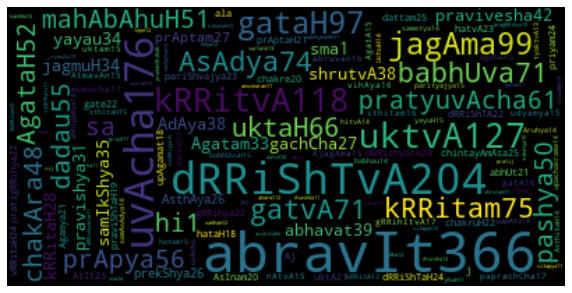

,kriya,verb,freq
0,अब्रवीत्,abravIt,366
1,दृष्ट्वा,dRRiShTvA,204
2,उवाच,uvAcha,176
3,उक्त्वा,uktvA,127
4,कृत्वा,kRRitvA,118
5,जगाम,jagAma,99
6,गतः,gataH,97
7,कृतम्,kRRitam,75
8,आसाद्य,AsAdya,74
10,बभूव,babhUva,71


In [654]:
from wordcloud import WordCloud
import matplotlib.font_manager as fm
# SANKSRIT_FONT = '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/121aa4b43e7e780f6614d6a0309de94f38937bb2.asset/AssetData/TiroSanskrit.ttc'
# prop = fm.FontProperties(fname=SANKSRIT_FONT)

itrans_text = " ".join(iitk_ramayana_verbs.sort_values(by=['pada']).pada.apply(
    lambda x: transliterate(x, sanscript.DEVANAGARI, sanscript.ITRANS) + str(iitk_ramayana_freq_count.set_index('kriya').loc[x].freq)
).to_list()).replace(" cha1 ", "")

# Generate a word cloud image
# wordcloud = WordCloud(collocations=False).generate(text)
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")

# lower max_font_size
itrans_wordcloud = WordCloud(max_font_size=40, collocations=False, background_color="black",  ).generate(itrans_text)
plt.figure(figsize=(10,15))
plt.imshow(itrans_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
iitk_ramayana_freq_count.head(30).style.set_caption("<b>IITK Ramayana Verb Freq Count- Top words</b>")


In [607]:
# SANKSRIT_FONT = '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/121aa4b43e7e780f6614d6a0309de94f38937bb2.asset/AssetData/TiroSanskrit.ttc'
# devanagari_text = " ".join(iitk_ramayana_verbs.sort_values(by=['pada']).pada.to_list())
# devanagari_wordcloud = WordCloud(
#     font_path=SANKSRIT_FONT,
#     max_font_size=40, collocations=False).generate(devanagari_text)
# image = devanagari_wordcloud.to_image()
# image.show()